# Plot variable on original FESOM grid

In many cases it is fine to first interpolate FESOM data to the regular grid and then plot them. Usually it will allow you to make plots faster. However sometimes you would like to work with original FESOM triangular mesh. 

If you don't need interactivity on the plots, comment:

    #%matplotlib notebook

In [4]:
import sys
sys.path.append("../")

import pyfesom as pf
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
%matplotlib notebook
from matplotlib import cm
from netCDF4 import Dataset

Load mesh

In [5]:
meshpath  ='../../../../FESOM/mesh/'
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=True)

The *usepickle = True* and the pickle file (*pickle_mesh*) exists.
 We load the mesh from it.


Load netCDF file that contains your data:

In [6]:
fl = Dataset('../../../../FESOM/data/fesom.2007.oce.nc')

There are several variables that we can plot:

In [7]:
fl.variables.keys()

[u'time', u'iter', u'ssh', u'u', u'v', u'w', u'wpot', u'temp', u'salt']

For every timestep there is a vector of values, each coresponding to the node of the model mesh.

In [8]:
fl.variables['temp'].shape

(12, 3668773)

In order to get values at some depth one should use *get_data* function from *pyfesom*. The input variables for this function are:

    data : array
        complete 3d data for one timestep
    mesh : fesom_mesh object
        mesh representation
    depth : int
        desired depth
        
As an output you will get: 

    level_data : array
        2d array (actually vector) with data from the desired level.
    elem_no_nan : array
        array with triangles (defined as triplets of node indexes) with
        not NaN elements.
        
The actual model level will be printed out.

Here is the result of requesting data from the level that is closest to 500 meters:

In [9]:
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][0,:], mesh, 500)

For depth 500 model level 490.0 will be used


The information from *level_data* and *elem_no_nan* is enought to make the plot:

Define the map:

In [16]:
map = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = map(mesh.x2, mesh.y2)

Plot the data from the last timestep of our dataset at 100m depth:

For depth 100 model level 100.0 will be used


<IPython.core.display.Javascript object>


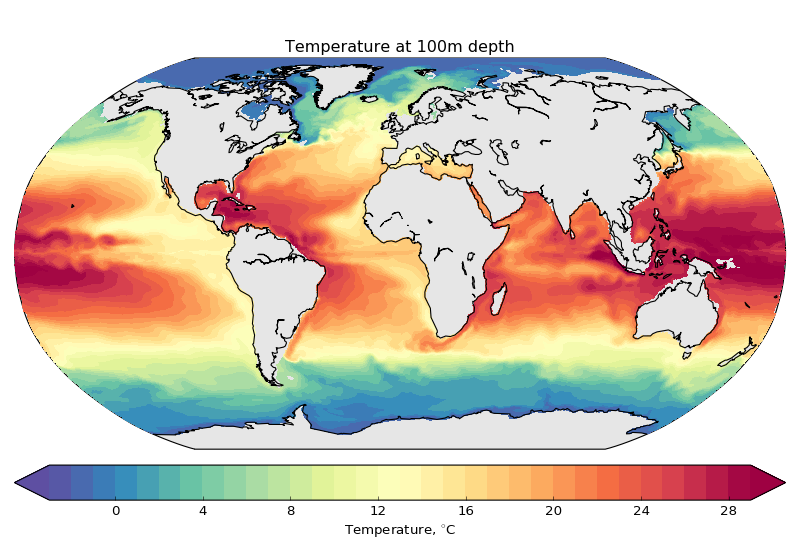

CPU times: user 1.3 s, sys: 28 ms, total: 1.33 s
Wall time: 1.45 s


In [11]:
%%time
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][-1,:],mesh,100)

plt.figure(figsize=(10,7))
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()

levels = np.arange(-3., 30., 1)
plt.tricontourf(x, y, elem_no_nan[::], level_data, levels = levels, cmap=cm.Spectral_r, extend='both')
cbar = plt.colorbar(orientation='horizontal', pad=0.03);
cbar.set_label("Temperature, $^{\circ}$C")
plt.title('Temperature at 100m depth')
plt.tight_layout()

If your color range covers the whole range of your data everything is fine. But if you try to narrow the range, the places with values outside your range become masked out:

For depth 100 model level 100.0 will be used


<IPython.core.display.Javascript object>


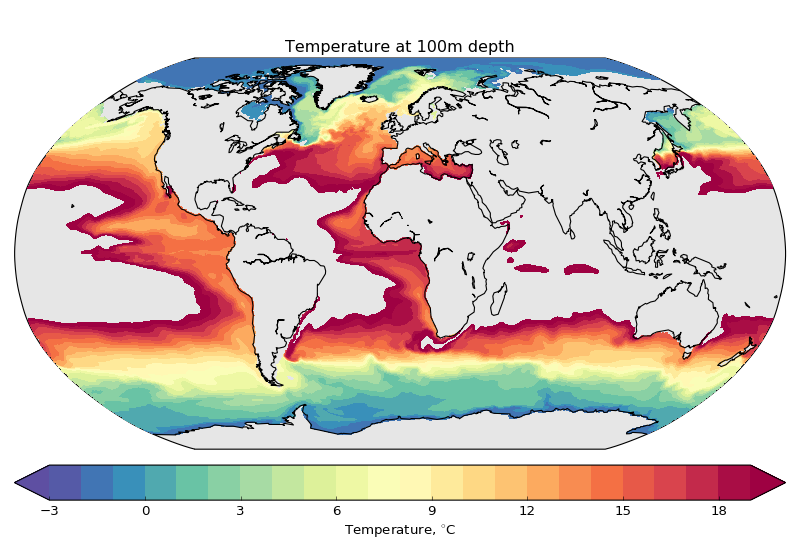

CPU times: user 820 ms, sys: 20 ms, total: 840 ms
Wall time: 841 ms


In [12]:
%%time
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][-1,:],mesh,100)

plt.figure(figsize=(10,7))
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()

levels = np.arange(-3., 20., 1)
plt.tricontourf(x, y, elem_no_nan[::], level_data, levels = levels, cmap=cm.Spectral_r, extend='both')
cbar = plt.colorbar(orientation='horizontal', pad=0.03);
cbar.set_label("Temperature, $^{\circ}$C")
plt.title('Temperature at 100m depth')
plt.tight_layout()

The way around it is to chnage your data :) 

For depth 100 model level 100.0 will be used


<IPython.core.display.Javascript object>


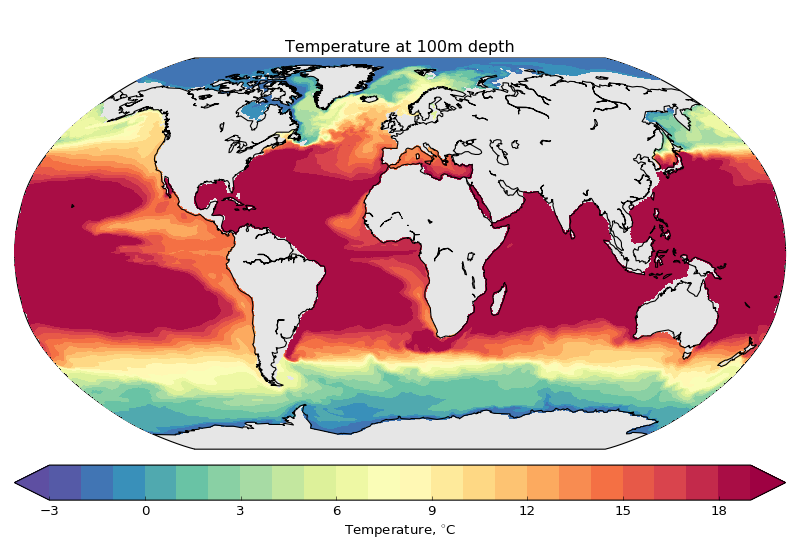

/home/magik/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal
/home/magik/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater_equal


CPU times: user 824 ms, sys: 72 ms, total: 896 ms
Wall time: 896 ms


In [13]:
%%time
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][-1,:],mesh,100)

plt.figure(figsize=(10,7))
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()

levels = np.arange(-3., 20., 1)

eps=(levels.max()-levels.min())/50.
level_data[level_data<=levels.min()]=levels.min()+eps
level_data[level_data>=levels.max()]=levels.max()-eps
plt.tricontourf(x, y, elem_no_nan[::], level_data, levels = levels, cmap=cm.Spectral_r, extend='both')
cbar = plt.colorbar(orientation='horizontal', pad=0.03);
cbar.set_label("Temperature, $^{\circ}$C")
plt.title('Temperature at 100m depth')
plt.tight_layout()

The things above were easy - since it was just doing contour plots. But sometimes it is nessesary to have a look at the data on original grid. Since properties in FESOM 1 are defined on the verticies of the triangles, the values for making the colors of the triangles will be calculated as a mean of the values in the verticies. 

For depth 100 model level 100.0 will be used


<IPython.core.display.Javascript object>


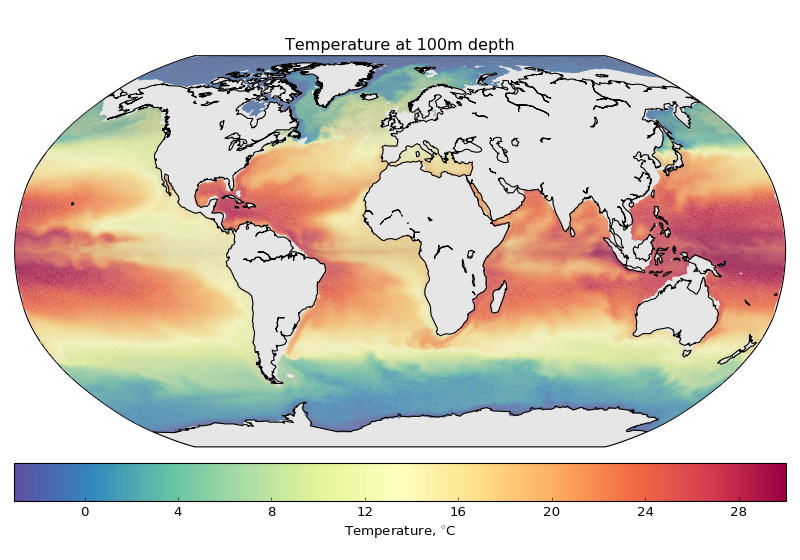

CPU times: user 11 s, sys: 2 s, total: 13 s
Wall time: 34.1 s


In [39]:
%%time
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][-1,:],mesh,100)

plt.figure(figsize=(10,7))
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()

plt.tripcolor(x, y, elem_no_nan, \
              level_data, \
              edgecolors='k',\
              lw = 0.01,
             cmap=cm.Spectral_r,
             vmin = -3,
             vmax = 30)
cbar = plt.colorbar(orientation='horizontal', pad=0.03);
cbar.set_label("Temperature, $^{\circ}$C")
plt.title('Temperature at 100m depth')
plt.tight_layout()


As you can see this takes considerably longer time. If you would like to have a look at the values exactly on the points were they are defined, you can try to use technique described in the *fesom_with_datashader.ipynb* tootorial.

In [46]:
m = Basemap(projection='mill',llcrnrlat=45,urcrnrlat=60,\
            llcrnrlon=-10,urcrnrlon=15,resolution='c')
x2, y2 = m(mesh.x2, mesh.y2)

For depth 0 model level -0.0 will be used


<IPython.core.display.Javascript object>


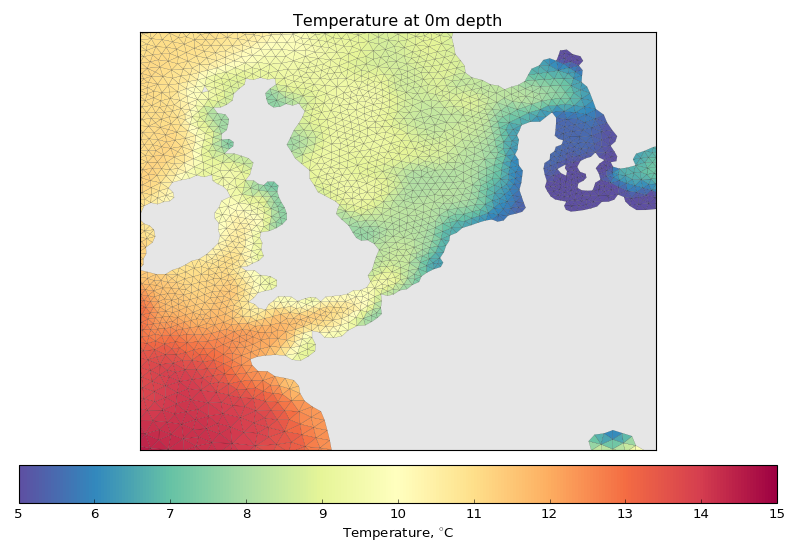

CPU times: user 10.9 s, sys: 428 ms, total: 11.3 s
Wall time: 11.9 s


In [47]:
%%time
level_data, elem_no_nan = pf.get_data(fl.variables['temp'][-1,:],mesh,0)

plt.figure(figsize=(10,7))
m.drawmapboundary(fill_color='0.9')
#m.drawcoastlines()

plt.tripcolor(x2, y2, elem_no_nan, \
              level_data, \
              edgecolors='k',\
              lw = 0.1,
             cmap=cm.Spectral_r,
             vmin = 5,
             vmax = 15)
cbar = plt.colorbar(orientation='horizontal', pad=0.03);
cbar.set_label("Temperature, $^{\circ}$C")
plt.title('Temperature at 0m depth')
plt.tight_layout()